# Метод $k$ ближайших соседей

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/artem/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Зададим нужные константы для обучения:

In [ ]:
# we perform T*Q-fold cross validation (T*Q-fold CV)
T = 3  # number of performing cross validations
Q = 5  # number of folds
# we want to minimize fp, that is false alarm rate
SCORING = 'accuracy'  # precision = tp/(tp + fp)
MAX_NUMBER_OF_NEIGHBORS = 500

Загрузим подготовленные данные:

In [ ]:
from sklearn.externals import joblib

X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')

display(X_train)

Теперь произведём отбор признаков:

curr_k = 1 curr_weights = distance curr_avg_accuracy = 0.933294975194
curr_k = 11 curr_weights = distance curr_avg_accuracy = 0.929492675603
curr_k = 21 curr_weights = distance curr_avg_accuracy = 0.923515008194
curr_k = 31 curr_weights = distance curr_avg_accuracy = 0.919008871148
curr_k = 41 curr_weights = distance curr_avg_accuracy = 0.916403913976
curr_k = 51 curr_weights = distance curr_avg_accuracy = 0.913771540767
curr_k = 61 curr_weights = distance curr_avg_accuracy = 0.910947210179
curr_k = 71 curr_weights = distance curr_avg_accuracy = 0.908689604275
curr_k = 81 curr_weights = distance curr_avg_accuracy = 0.906879828738
curr_k = 91 curr_weights = distance curr_avg_accuracy = 0.90583785389
curr_k = 101 curr_weights = distance curr_avg_accuracy = 0.90448510129
curr_k = 111 curr_weights = distance curr_avg_accuracy = 0.903141513687
curr_k = 121 curr_weights = distance curr_avg_accuracy = 0.901871025491
curr_k = 131 curr_weights = distance curr_avg_accuracy = 0.900627969624
curr_

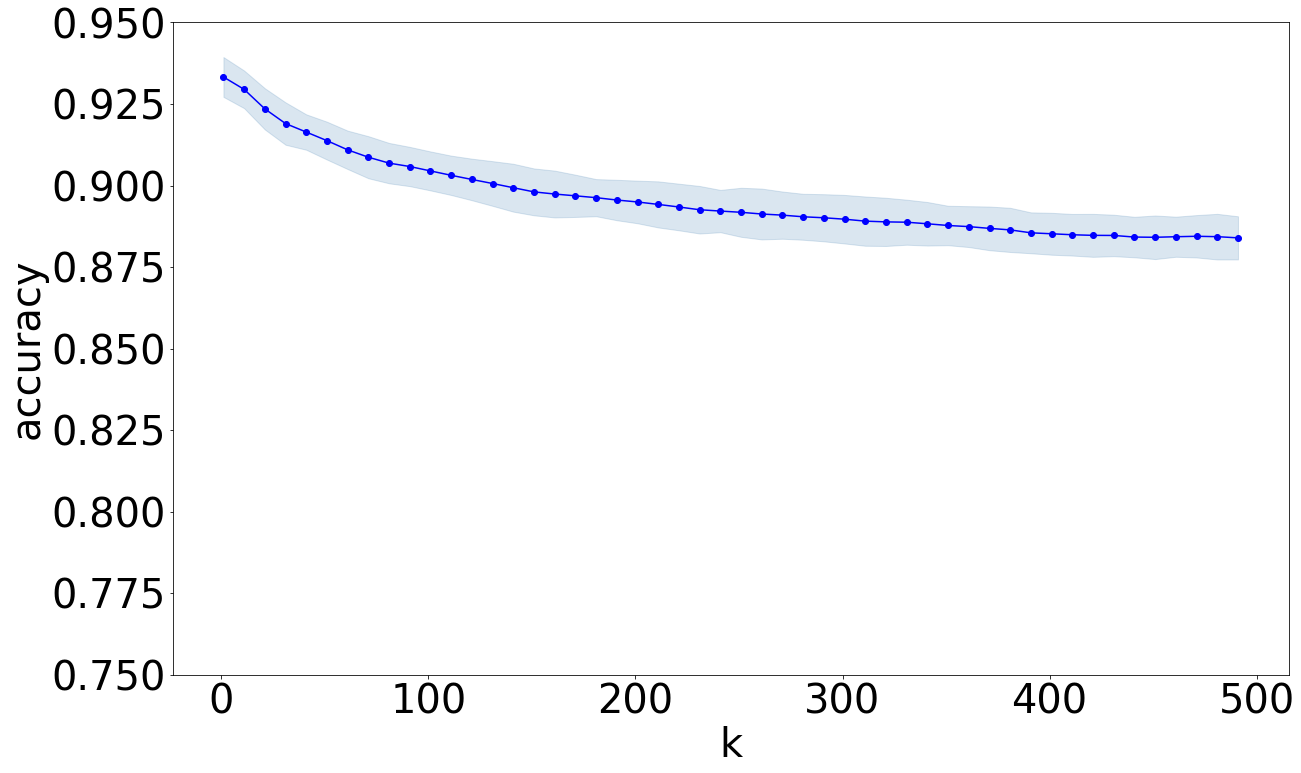

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix


def test_classifier(classifier, X, y):
    tns, fps, fns, tps = ([], [], [], [])

    rkf = RepeatedKFold(n_splits=Q, n_repeats=T, random_state=32)
    for train_index, test_index in rkf.split(X):
        curr_X_train, curr_X_test = X.iloc[train_index], X.iloc[test_index]
        curr_y_train, curr_y_test = y.iloc[train_index], y.iloc[test_index]
        classifier.fit(curr_X_train, curr_y_train)
        curr_y_pred = classifier.predict(curr_X_test)
        curr_tn, curr_fp, curr_fn, curr_tp = (
            confusion_matrix(curr_y_test, curr_y_pred).ravel()
        )

        curr_test_size = curr_tn + curr_fp + curr_fn + curr_tp
        assert(curr_test_size == len(curr_X_test)
                   and curr_test_size == len(curr_y_test))
        tns.append({
            'tn': curr_tn,
            'test_size': curr_test_size,
            'tn_rate': curr_tn/curr_test_size,
        })
        fps.append({
            'fp': curr_fp,
            'test_size': curr_test_size,
            'fp_rate': curr_fp/curr_test_size,
        })
        fns.append({
            'fn': curr_fn,
            'test_size': curr_test_size,
            'fn_rate': curr_fn/curr_test_size,
        })
        tps.append({
            'tp': curr_tp,
            'test_size': curr_test_size,
            'tp_rate': curr_tp/curr_test_size,
        })

    tns_df = pd.DataFrame(tns)
    fps_df = pd.DataFrame(fps)
    fns_df = pd.DataFrame(fns)
    tps_df = pd.DataFrame(tps)
    return (tns_df, fps_df, fns_df, tps_df)


def make_plot(precisions, deviations, weights):
    assert(len(precisions) == len(deviations))
    plt.figure(figsize=(20, 12))
    
    upper = []
    lower = []
    for i in range(len(precisions)):
        upper.append(precisions[i] + deviations[i])
        lower.append(precisions[i] - deviations[i])
    plt.fill_between(
        [k for k in range(1, MAX_NUMBER_OF_NEIGHBORS + 1, 10)],
        upper,
        lower,
        alpha=0.2,
        color='steelblue',
        lw=1
    )
    
    # plt.grid(True)
    plt.ylim([0.75, 0.95])
    plt.xlabel('k', fontsize=40)
    plt.ylabel(SCORING, fontsize=40)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=40)
    ax.tick_params(axis='both', which='minor', labelsize=40)
    plt.plot(
        [k for k in range(1, MAX_NUMBER_OF_NEIGHBORS + 1, 10)],
        precisions,
        color='blue',
        marker='o'
    )
    plt.savefig(
        '../results/knn/{0}.svg'.format(weights),
        format='svg',
        dpi=300
    )



def choose_hyperparameters(X_train, y_train):
    weights = ('distance',)  # 'uniform')
    neighbors_numbers = [k for k in range(1, MAX_NUMBER_OF_NEIGHBORS + 1, 10)]
    best_accuracy = 0.0
    
    for curr_weights in weights:
        accuracies = []
        deviations = []
        for curr_k in neighbors_numbers:
            curr_knn_classifier = KNeighborsClassifier(n_neighbors=curr_k,
                                                       weights=curr_weights)
            curr_tns_df, curr_fps_df, curr_fns_df, curr_tps_df = (
                test_classifier(curr_knn_classifier, X_train, y_train)
            )
            
            curr_accuracies = []
            for i in range(T*Q):
                curr_tn_rate = curr_tns_df.at[i, 'tn_rate']
                curr_fp_rate = curr_fps_df.at[i, 'fp_rate']
                curr_fn_rate = curr_fns_df.at[i, 'fn_rate']
                curr_tp_rate = curr_tps_df.at[i, 'tp_rate']
                curr_accuracies.append(
                    (curr_tp_rate + curr_tn_rate)/
                    (curr_tp_rate + curr_tn_rate + curr_fp_rate + curr_fn_rate)
                )
            curr_avg_accuracy = sum(curr_accuracies)/len(curr_accuracies)
            accuracies.append(curr_avg_accuracy)
            deviations.append(np.array(curr_accuracies).std()*2)
            
            if curr_avg_accuracy > best_accuracy:
                best_accuracy = curr_avg_accuracy
            print(
                'curr_k =', curr_k,
                'curr_weights =', curr_weights,
                'curr_avg_accuracy =', curr_avg_accuracy
            )
            
        make_plot(accuracies, deviations, curr_weights)


choose_hyperparameters(X_train, y_train)

### К этому моменту мы настроили гиперпараметры и отобрали признаки!

Теперь нужно указать подобранные гиперпараметры в качестве следующих констант:
* BEST_K        --- число ближайших соседей для классификатора по $k$ ближайшим соседям
* BEST_WEIGHTS  --- весовые коэффициенты расстояний ('uniform' или 'distance')
* BEST_FEATURES --- индексы колонок с отобранными признаками

In [3]:
BEST_K = 1
BEST_WEIGHTS = 'uniform'
BEST_FEATURES = [
    1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 20,
    21, 22, 23, 26, 27, 30, 31, 32, 34, 36, 37, 38, 39, 40,
    41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60,
    61, 62, 63, 65, 66, 67, 68, 71, 72, 74, 76, 77, 78, 79, 80,
    81, 83, 84, 86, 88, 89, 91, 92, 93, 94, 95
]

Теперь отфильтруем признаки в X_train:

In [4]:
X_train = X_train.iloc[:, BEST_FEATURES]
display(X_train)

,DIRECTORY_ENTRY_DEBUG/exists,DIRECTORY_ENTRY_DELAY_IMPORT/exists,DIRECTORY_ENTRY_IMPORT/exists,DIRECTORY_ENTRY_RESOURCE/exists,DIRECTORY_ENTRY_TLS/exists,DOSStub/entropy,DOS_HEADER.e_cblp,DOS_HEADER.e_cp,DOS_HEADER.e_cparhdr,DOS_HEADER.e_crlc,...,SECTIONS.SizeOfRawData/alignment,SECTIONS.SizeOfRawData/zero,SECTIONS/entry_point_in_last_section,SECTIONS/executable_sections,SECTIONS/max_section_entropy,SECTIONS/sections_with_zero_entropy_count,SECTIONS/text_section_entropy,SECTIONS/unusual_section_names,SECTIONS/writeable_and_executable_sections,SECTIONS/writeable_sections
26682,-0.079078,-0.150130,0.020719,0.333973,-0.507212,0.569661,-0.011388,-0.039358,-0.030408,-0.027934,...,-0.211780,0.419469,-0.227519,-0.269120,-0.377887,0.258948,0.546524,-0.460900,-0.288560,-0.094187
50916,-0.079078,-0.150130,0.020719,0.333973,-0.507212,0.373237,-0.011388,-0.039358,-0.030408,-0.027934,...,-0.211780,0.419469,-0.227519,-0.269120,-0.444852,0.258948,0.525452,-0.460900,-0.288560,-0.094187
29258,-0.079078,-0.150130,-0.078087,0.333973,-0.507212,0.333303,-0.011388,-0.039358,-0.030408,-0.027934,...,-0.211780,-0.612184,-0.227519,-0.269120,-0.268217,-0.665014,0.581034,-0.460900,-0.288560,-0.094187
18211,0.129710,1.233757,0.712365,0.333973,-0.507212,0.630445,-0.011388,-0.039358,-0.030408,-0.027934,...,-0.211780,-0.612184,-0.227519,-0.269120,-0.252136,-0.665014,0.586095,-0.460900,-0.288560,-0.655287
31183,-0.079078,-0.150130,0.020719,0.333973,-0.507212,0.467182,-0.011388,-0.039358,-0.030408,-0.027934,...,-0.211780,0.419469,-0.227519,-0.269120,-0.383324,0.258948,0.544813,-0.460900,-0.288560,-0.094187
54395,-0.079078,-0.150130,0.020719,-2.994258,-0.507212,0.333303,-0.011388,-0.039358,-0.030408,-0.027934,...,3.379382,0.419469,4.395228,0.569053,0.459248,0.258948,0.809948,0.131280,0.518246,1.028014
27351,-0.079078,-0.150130,0.020719,0.333973,-0.507212,0.421855,-0.011388,-0.039358,-0.030408,-0.027934,...,-0.211780,0.419469,-0.227519,-0.269120,-0.335065,0.258948,0.559999,-0.460900,-0.288560,-0.094187
27791,-0.079078,8.845135,1.601623,0.333973,1.971561,-1.770532,-0.102259,-0.040274,-0.030408,-0.027934,...,0.985274,1.451121,-0.227519,0.569053,0.242980,1.182910,0.534680,-0.460900,-0.288560,1.589115
19336,-0.079078,-0.150130,0.020719,0.333973,-0.507212,0.629202,-0.011388,-0.039358,-0.030408,-0.027934,...,-0.211780,0.419469,-0.227519,-0.269120,1.378243,0.258948,0.562126,-0.460900,-0.288560,-0.094187
27617,0.547286,-0.150130,-0.374507,0.333973,-0.507212,0.611762,-0.011388,-0.039358,-0.030408,-0.027934,...,-0.211780,-0.612184,-0.227519,-0.269120,-1.062610,-0.665014,0.331061,-0.460900,-0.288560,-0.655287


Создадим объект классификатора с настроенными гиперпараметрами:

In [5]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=BEST_K,
                                      weights=BEST_WEIGHTS)

Обучим классификатор на обучающей выборке (X_train, y_train):

In [6]:
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### На данном этапе процесс обучения завершён!

Сохраним классификатор на диск.

In [7]:
from sklearn.externals import joblib
joblib.dump(knn_classifier, '../results/knn/knn_classifier.pkl')

['../results/knn/knn_classifier.pkl']